In [9]:
from google.colab import files
uploaded = files.upload()

Saving female population.xlsx to female population.xlsx


In [111]:
import pandas as pd
import numpy as np
import calendar
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load data
df = pd.read_excel("monthly region data.xlsx", sheet_name="Data")
df['year'] = df['year'].astype(int)
df['month_num'] = df['month'].apply(lambda x: list(calendar.month_name).index(x))
df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month_num'].astype(str) + '-01')

# Aggregate Scotland-level data (for comparison)
scotland_df = df.groupby('date')['birth_count'].sum().reset_index()
scotland_df.rename(columns={'date':'ds', 'birth_count':'y'}, inplace=True)

# Train-test split: last 12 months as test
train = scotland_df[:-12]
test = scotland_df[-12:]
y_true = test['y'].values


In [112]:
from prophet import Prophet

prophet = Prophet(yearly_seasonality=True)
prophet.fit(train)

future = prophet.make_future_dataframe(periods=12, freq='M')
forecast_prophet = prophet.predict(future)

y_pred_prophet = forecast_prophet['yhat'][-12:].values
mae_prophet = mean_absolute_error(y_true, y_pred_prophet)
rmse_prophet = np.sqrt(mean_squared_error(y_true, y_pred_prophet))
mape_prophet = np.mean(np.abs((y_true - y_pred_prophet) / y_true)) * 100


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hhmnoic/5_wh90i1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hhmnoic/8voafq8x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56550', 'data', 'file=/tmp/tmp_hhmnoic/5_wh90i1.json', 'init=/tmp/tmp_hhmnoic/8voafq8x.json', 'output', 'file=/tmp/tmp_hhmnoic/prophet_model9rkazt4s/prophet_model-20250801123447.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:34:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:34:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/

In [113]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(train['y'], order=(1,1,1), seasonal_order=(1,1,1,12))
sarima_fit = sarima_model.fit(disp=False)

y_pred_sarima = sarima_fit.forecast(steps=12)
mae_sarima = mean_absolute_error(y_true, y_pred_sarima)
rmse_sarima = np.sqrt(mean_squared_error(y_true, y_pred_sarima))
mape_sarima = np.mean(np.abs((y_true - y_pred_sarima) / y_true)) * 100


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



In [114]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

df_ml = scotland_df.copy()
df_ml['lag1'] = df_ml['y'].shift(1)
df_ml['lag2'] = df_ml['y'].shift(2)
df_ml['month'] = df_ml['ds'].dt.month
df_ml['year'] = df_ml['ds'].dt.year
df_ml = df_ml.dropna()

X = df_ml[['lag1','lag2','month','year']]
y = df_ml['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=12, shuffle=False)

xgb = XGBRegressor(objective='reg:squarederror', n_estimators=200)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mape_xgb = np.mean(np.abs((y_test - y_pred_xgb) / y_test)) * 100


In [115]:
results = pd.DataFrame({
    "Model": ["Prophet", "SARIMA", "XGBoost"],
    "MAE": [mae_prophet, mae_sarima, mae_xgb],
    "RMSE": [rmse_prophet, rmse_sarima, rmse_xgb],
    "MAPE (%)": [mape_prophet, mape_sarima, mape_xgb]
})

print("📊 Model Comparison:")
print(results)


📊 Model Comparison:
     Model          MAE         RMSE   MAPE (%)
0  Prophet   658.185560   826.133395   8.695818
1   SARIMA   661.999171   891.977482   8.646585
2  XGBoost  1210.746826  2223.974033  15.600410


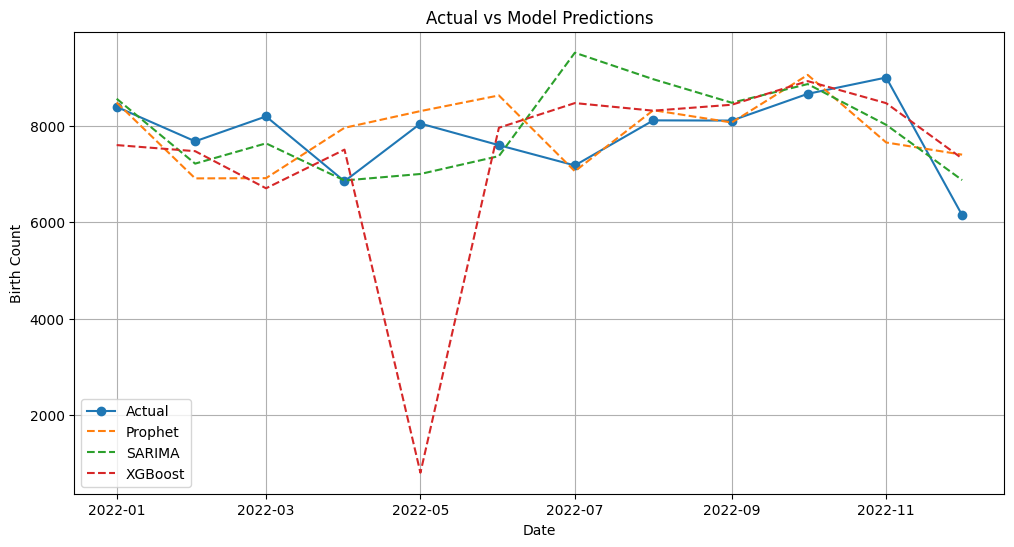

In [116]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(test['ds'], y_true, label="Actual", marker='o')
plt.plot(test['ds'], y_pred_prophet, label="Prophet", linestyle="--")
plt.plot(test['ds'], y_pred_sarima, label="SARIMA", linestyle="--")
plt.plot(test['ds'], y_pred_xgb, label="XGBoost", linestyle="--")
plt.legend()
plt.title("Actual vs Model Predictions")
plt.xlabel("Date")
plt.ylabel("Birth Count")
plt.grid(True)
plt.show()
